In [2]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy import stats
from datetime import datetime as dt

## DBSCAN

In [2]:
def plot_clusters(values, min_cluster_size=5, min_samples=15, cluster_selection_method='leaf'):
    h, bin_edges = np.histogram(values, bins=120)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    h_mov_avg = np.convolve(h, np.ones((3,))/3, mode='same')
    X = h_mov_avg.reshape(-1, 1)
    X = (X - X.mean()) / X.std()

    data = np.column_stack((bin_centers, X))
    print(data.shape)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_method=cluster_selection_method)
    labels = clusterer.fit_predict(data)
    plt.scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')
    plt.show()
    #return labels

(120, 2)


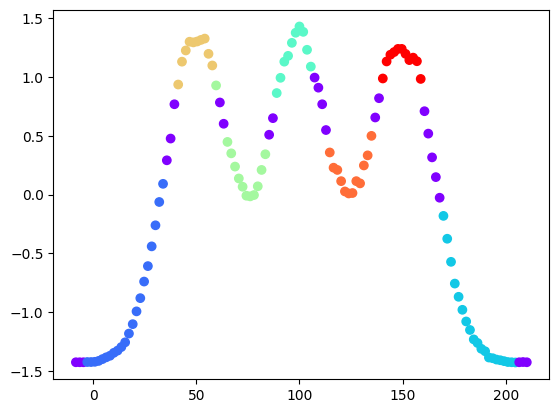

In [10]:
a = np.random.normal(50, 15, 10000)
b = np.random.normal(100, 15, 10000)
c = np.random.normal(150, 15, 10000)

plot_clusters(np.concatenate((a, b, c)), 6, 7, 'leaf')

(120, 2)


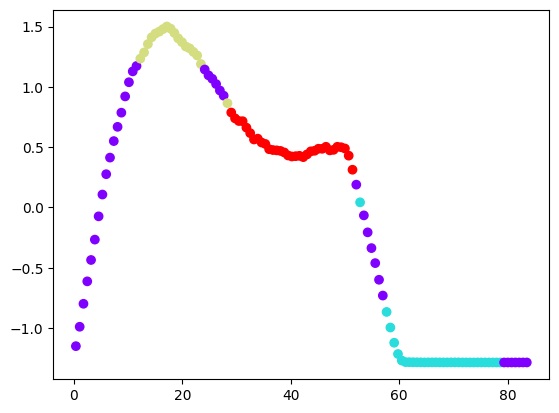

In [11]:
a = np.random.rayleigh(15, 100000)
b = np.random.triangular(0, 50, 60, 100000)
values = np.concatenate((a, b))
l = plot_clusters(values, 5, 15, 'leaf')

## GMM

In [11]:
def plot_GMM(X, n_components=5):
    # fit models with 1-10 components
    N = np.arange(1, n_components+1)
    x = np.arange(0, len(X)).reshape(-1, 1)

    models = [None for i in range(len(N))]
    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(X)

    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models] # Akaike Information Criterion
    BIC = [m.bic(X) for m in models] # Bayesian Information Criterion

    # Compute the best model
    M_best = models[np.argmin(AIC)]
    MU = [M_best.means_.flatten()]
    SIGMA = [np.sqrt(M_best.covariances_.flatten())]
    W = [M_best.weights_.flatten()]

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    x = np.linspace(min(X), max(X), 1000)
    pdf = np.exp(M_best.score_samples(x.reshape(-1, 1)))

    ax[0].hist(X, bins=60, density=True, alpha=0.5, label='Data')
    ax[0].plot(x, pdf, '-k', label='Best fit')
    for i in range(M_best.n_components):
        ax[0].plot(x, W[0][i]*stats.norm.pdf(x, MU[0][i], SIGMA[0][i]), label='Gaussian {}'.format(i+1), ls='--')
    ax[0].legend()

    ax[1].plot(N, AIC, '-k', label='AIC')
    ax[1].plot(N, BIC, '--k', label='BIC')
    ax[1].set_xlabel('n. components')
    ax[1].set_ylabel('information criterion')
    ax[1].legend()

    plt.show()

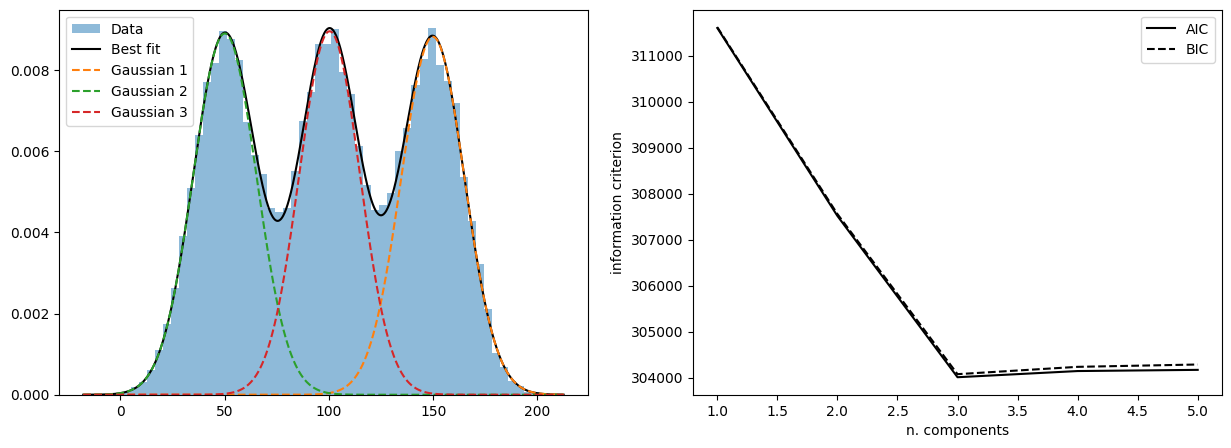

In [15]:
a = np.random.normal(50, 15, 10000)
b = np.random.normal(100, 15, 10000)
c = np.random.normal(150, 15, 10000)

X = np.concatenate((a,b,c)).reshape(-1, 1)
plot_GMM(X)

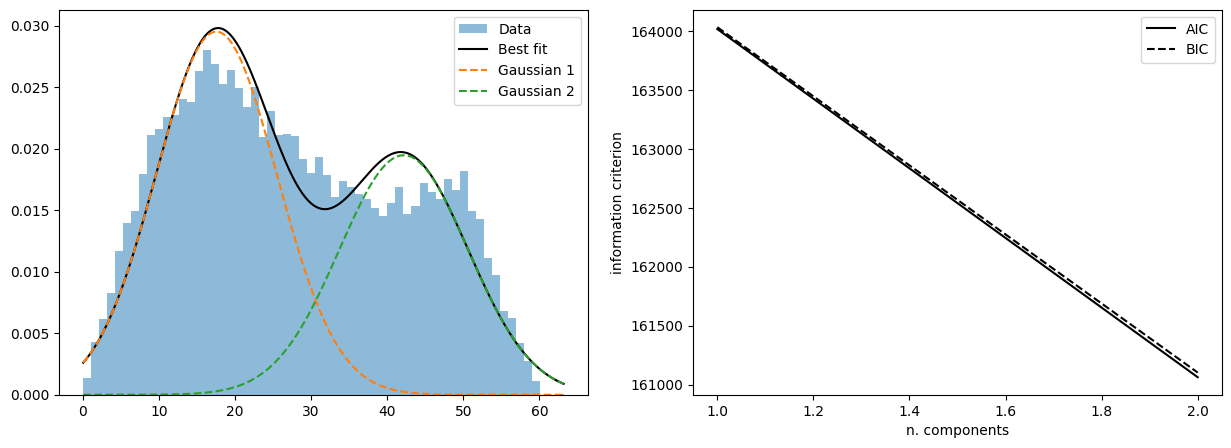

In [17]:
a = np.random.rayleigh(15, 10000)
b = np.random.triangular(0, 50, 60, 10000)
X = np.concatenate((a, b)).reshape(-1, 1)
plot_GMM(X, 2)

## Test Data

In [117]:
df = pd.read_csv('datasets/test.csv')
df.head()

,time,bandwidth,throughput,avg_response_time,avg_connect_time,avg_latency
0,21:41:51,1699040.0,2.67,191.25,60.88,137.75
1,21:41:54,1274397.0,2.00,230.50,45.50,146.17
2,21:41:57,1486742.0,2.33,221.00,44.29,149.29
3,21:42,1486797.0,2.33,307.86,51.00,216.14
4,21:42:03,1699081.0,2.67,511.88,45.88,260.63


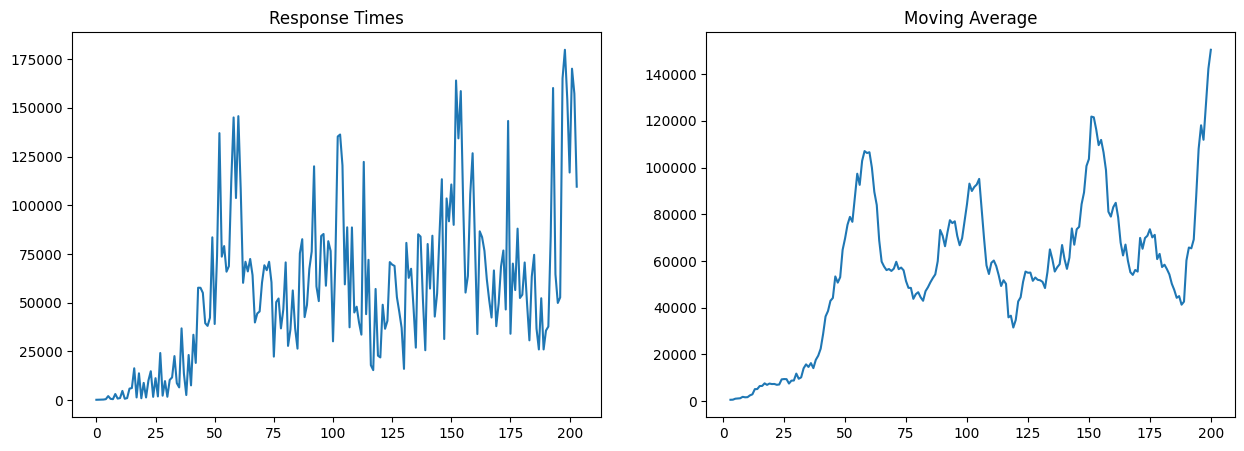

In [118]:
resp = df['avg_response_time'].values
time = np.arange(0, len(resp)).reshape(-1, 1)
resp_mov_avg = np.convolve(resp, np.ones(7)/7, mode='valid').reshape(-1, 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(time, resp)
ax[0].set_title('Response Times')
ax[1].plot(time[3:-3], resp_mov_avg)
ax[1].set_title('Moving Average')
plt.show()

In [119]:
scale = resp_mov_avg.sum() / 30000
h = np.concatenate([np.full((int(resp_mov_avg[i][0] // scale), 1), i) for i in range(len(resp_mov_avg))])
h.shape

(29900, 1)

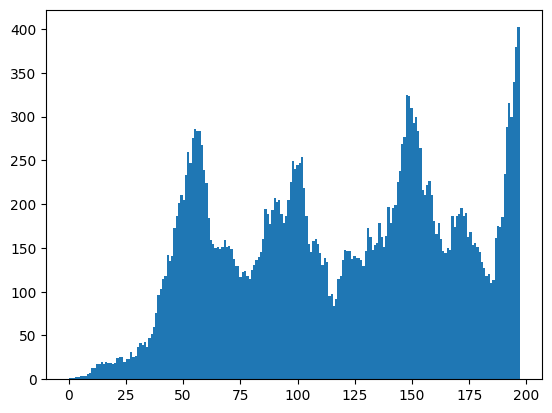

In [120]:
plt.hist(h.flatten(), bins=len(resp_mov_avg))
plt.show()

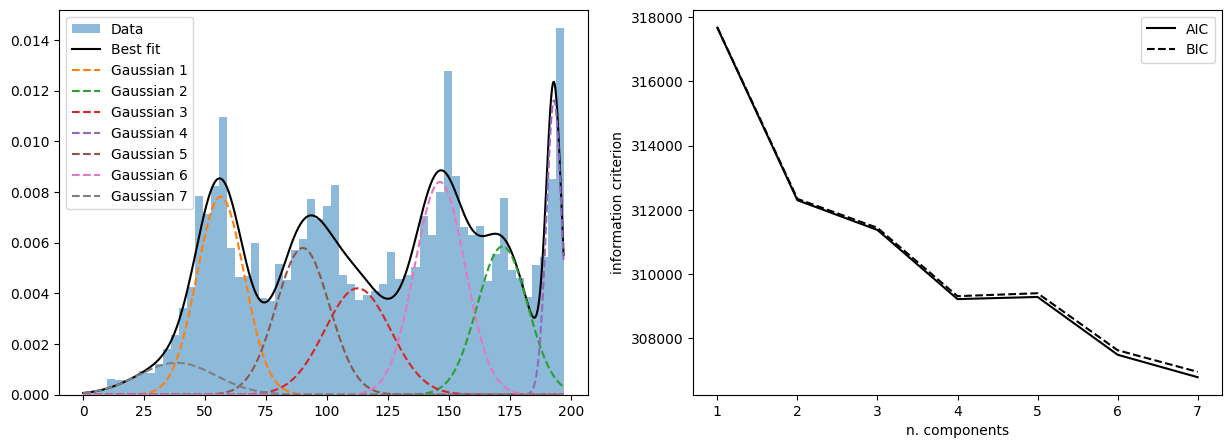

In [115]:
plot_GMM(h, 7)

(120, 2)


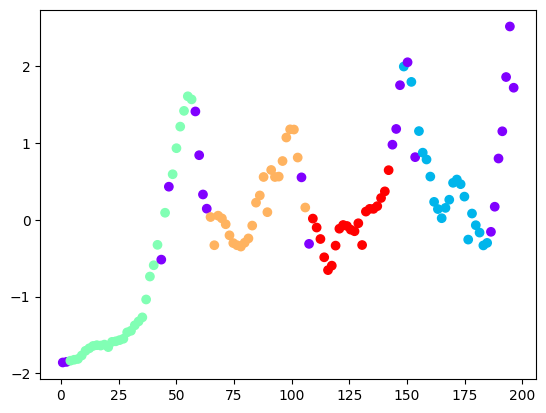

In [128]:
plot_clusters(h, 6, 4, 'leaf')

## Dataset 1

In [3]:
df = pd.read_csv('datasets/daily-website-visitors.csv')
df['Page.Loads'] = df['Page.Loads'].apply(lambda x: int(x.replace(',', '')))
print(df.shape)
df.head()

(2167, 8)


,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,"1,582","1,430",152
1,2,Monday,2,9/15/2014,3621,"2,528","2,297",231
2,3,Tuesday,3,9/16/2014,3698,"2,630","2,352",278
3,4,Wednesday,4,9/17/2014,3667,"2,614","2,327",287
4,5,Thursday,5,9/18/2014,3316,"2,366","2,130",236


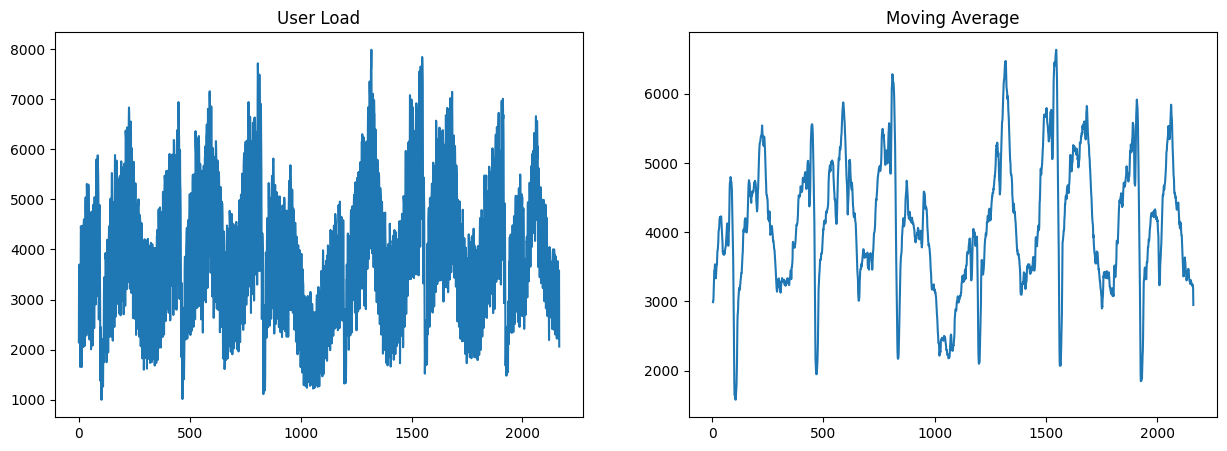

In [6]:
resp = df['Page.Loads'].values
time = np.arange(0, len(resp)).reshape(-1, 1)
resp_mov_avg = np.convolve(resp, np.ones(7)/7, mode='valid').reshape(-1, 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(time, resp)
ax[0].set_title('User Load')
ax[1].plot(time[3:-3], resp_mov_avg)
ax[1].set_title('Moving Average')
plt.show()

(28949, 1)


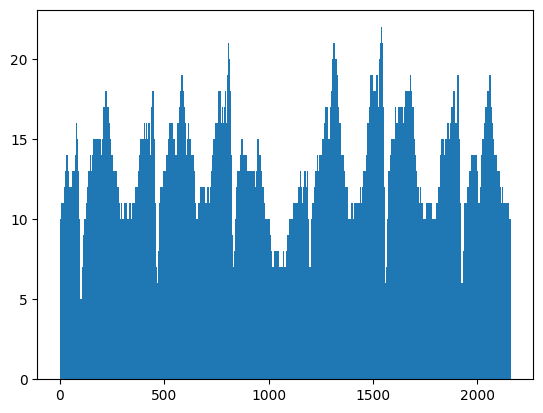

In [8]:
scale = resp_mov_avg.sum() / 30000
h = np.concatenate([np.full((int(resp_mov_avg[i][0] // scale), 1), i) for i in range(len(resp_mov_avg))])
print(h.shape)
plt.hist(h.flatten(), bins=len(resp_mov_avg))
plt.show()

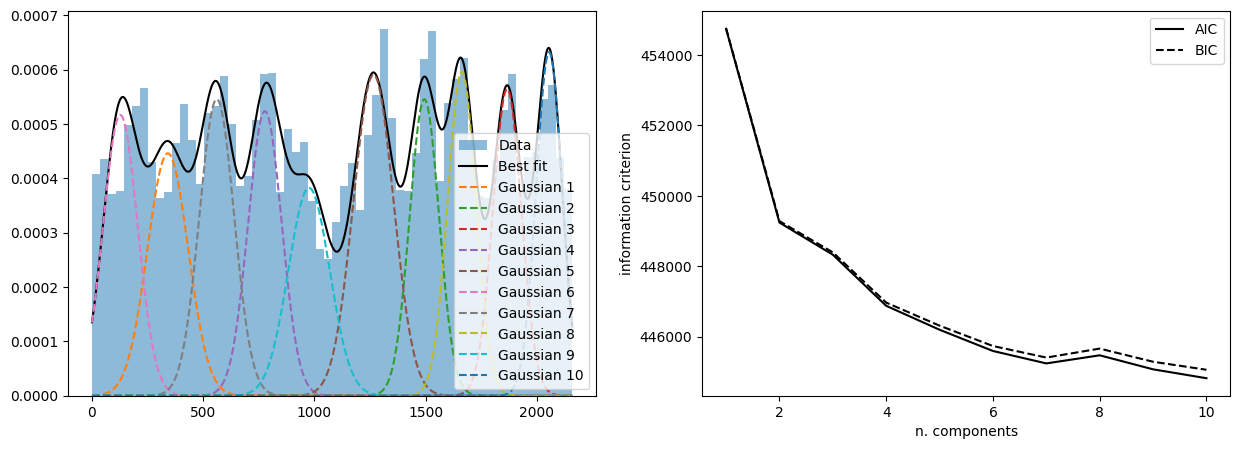

In [14]:
plot_GMM(h, 10)

## Excel Data

### Sheet: A

In [143]:
df = pd.read_excel('datasets/req_distr_dataset.xlsx', 'A')
df.head()

,Date,StartTime,Date.1,StartTime.1,Date.2,StartTime.2,Date.3,StartTime.3
0,2022-06-22,12:59:56,2022-06-22,06:59:56,2022-06-25,04:59:59,2022-06-26,03:59:59
1,2022-06-22,12:59:55,2022-06-22,06:59:54,2022-06-25,04:59:59,2022-06-26,03:59:56
2,2022-06-22,12:59:44,2022-06-22,06:59:54,2022-06-25,04:59:59,2022-06-26,03:59:56
3,2022-06-22,12:59:42,2022-06-22,06:59:54,2022-06-25,04:59:59,2022-06-26,03:59:54
4,2022-06-22,12:59:42,2022-06-22,06:59:53,2022-06-25,04:59:59,2022-06-26,03:59:54


In [144]:
df1 = df['StartTime'].dropna()
df2 = df['StartTime.1'].dropna()
df3 = df['StartTime.2'].dropna()
df4 = df['StartTime.3'].dropna()

print(df1.shape, df2.shape, df3.shape, df4.shape)

(100,) (100,) (250,) (374,)


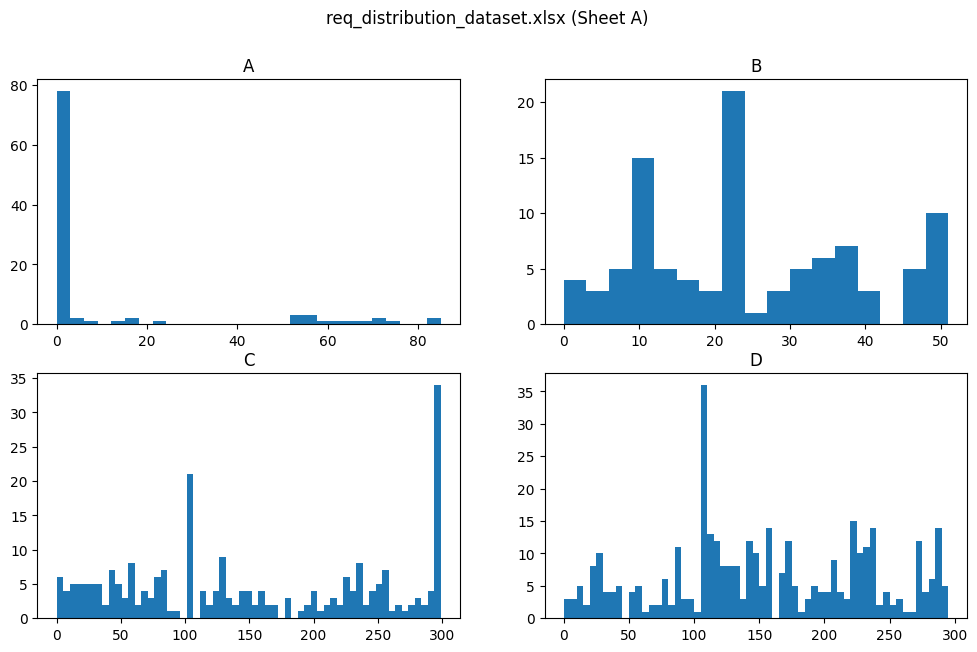

In [146]:
reqs1 = df1.apply(lambda t: t.hour*3600 + t.minute*60 + t.second).values
reqs2 = df2.apply(lambda t: t.hour*3600 + t.minute*60 + t.second).values
reqs3 = df3.apply(lambda t: t.hour*3600 + t.minute*60 + t.second).values
reqs4 = df4.apply(lambda t: t.hour*3600 + t.minute*60 + t.second).values

reqs1 -= reqs1.min()
reqs2 -= reqs2.min()
reqs3 -= reqs3.min()
reqs4 -= reqs4.min()

fig, ax = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle('req_distribution_dataset.xlsx (Sheet A)')

ax[0, 0].hist(reqs1, bins=(reqs1.max() - reqs1.min()) // 3)
ax[0, 0].set_title('A')
ax[0, 1].hist(reqs2, bins=(reqs2.max() - reqs2.min()) // 3)
ax[0, 1].set_title('B')
ax[1, 0].hist(reqs3, bins=(reqs3.max() - reqs3.min()) // 5)
ax[1, 0].set_title('C')
ax[1, 1].hist(reqs4, bins=(reqs4.max() - reqs4.min()) // 5)
ax[1, 1].set_title('D')

plt.show()

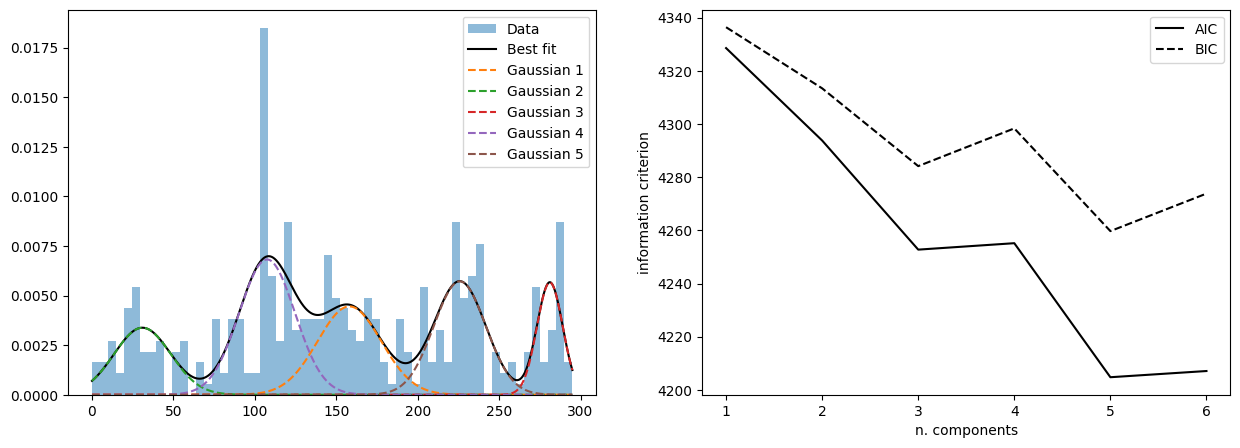

In [135]:
plot_GMM(reqs4.reshape(-1, 1), 6)

### Sheet: B

In [150]:
df = pd.read_excel('datasets/req_distr_dataset.xlsx', 'B')
df.head()

,Request Time,Request Time.1,Request Time.2,Request Time.3,Request Time.4,Request Time.5,Request Time.6
0,2022-06-22 12:58:00,2022-06-22 18:59:01,2022-06-23 12:58:00,2022-06-24 19:59:02,2022-06-25 16:55:00,2022-06-26 15:55:00,2022-06-25 04:59:59
1,2022-06-22 12:58:00,2022-06-22 18:59:01,2022-06-23 12:58:00,2022-06-24 19:59:04,2022-06-25 16:55:01,2022-06-26 15:55:01,2022-06-25 04:59:50
2,2022-06-22 12:58:00,2022-06-22 18:59:01,2022-06-23 12:58:01,2022-06-24 19:59:06,2022-06-25 16:55:01,2022-06-26 15:55:01,2022-06-25 04:59:49
3,2022-06-22 12:58:00,2022-06-22 18:59:01,2022-06-23 12:58:03,2022-06-24 19:59:06,2022-06-25 16:55:01,2022-06-26 15:55:02,2022-06-25 04:59:45
4,2022-06-22 12:58:01,2022-06-22 18:59:03,2022-06-23 12:58:04,2022-06-24 19:59:06,2022-06-25 16:55:01,2022-06-26 15:55:02,2022-06-25 04:59:38


In [151]:
df1 = df['Request Time'].dropna()
df2 = df['Request Time.1'].dropna()
df3 = df['Request Time.2'].dropna()
df4 = df['Request Time.3'].dropna()
df5 = df['Request Time.4'].dropna()
df6 = df['Request Time.5'].dropna()

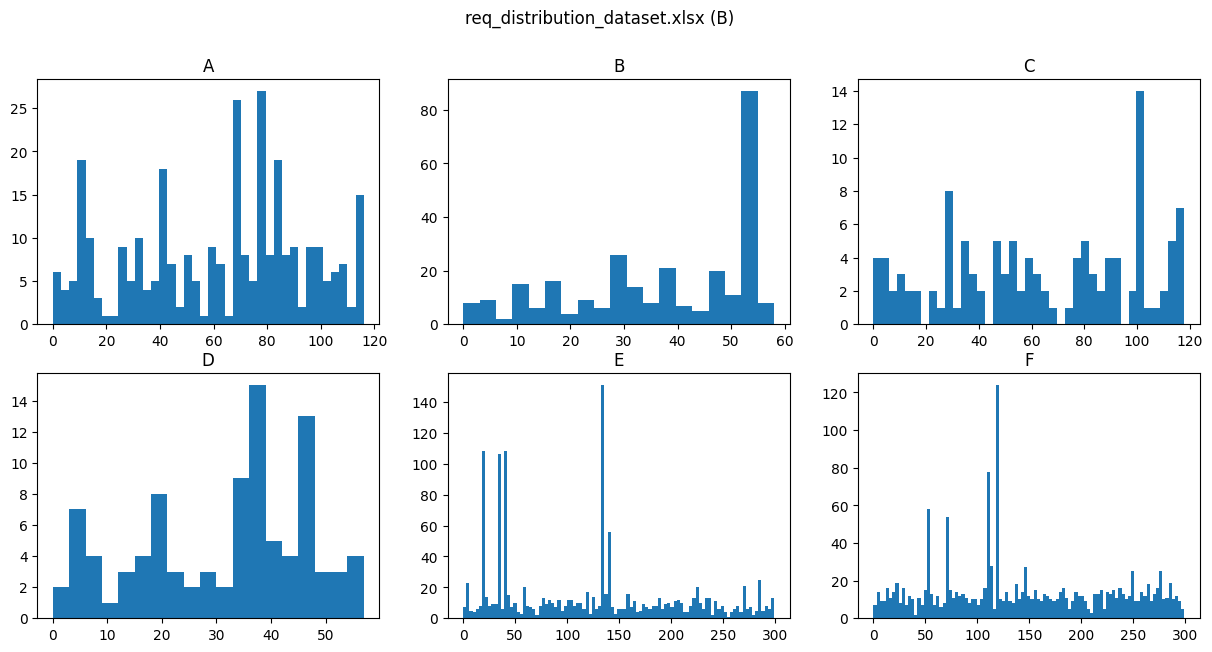

In [152]:
reqs1 = df1.apply(lambda t: dt.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()).values
reqs2 = df2.apply(lambda t: dt.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()).values
reqs3 = df3.apply(lambda t: dt.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()).values
reqs4 = df4.apply(lambda t: dt.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()).values
reqs5 = df5.apply(lambda t: dt.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()).values
reqs6 = df6.apply(lambda t: dt.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()).values

reqs1 -= reqs1.min()
reqs2 -= reqs2.min()
reqs3 -= reqs3.min()
reqs4 -= reqs4.min()
reqs5 -= reqs5.min()
reqs6 -= reqs6.min()

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
fig.suptitle('req_distribution_dataset.xlsx (B)')

ax[0, 0].hist(reqs1, bins=round((reqs1.max() - reqs1.min()) // 3))
ax[0, 0].set_title('A')
ax[0, 1].hist(reqs2, bins=round((reqs2.max() - reqs2.min()) // 3))
ax[0, 1].set_title('B')
ax[0, 2].hist(reqs3, bins=round((reqs3.max() - reqs3.min()) // 3))
ax[0, 2].set_title('C')
ax[1, 0].hist(reqs4, bins=round((reqs4.max() - reqs4.min()) // 3))
ax[1, 0].set_title('D')
ax[1, 1].hist(reqs5, bins=round((reqs5.max() - reqs5.min()) // 3))
ax[1, 1].set_title('E')
ax[1, 2].hist(reqs6, bins=round((reqs6.max() - reqs6.min()) // 3))
ax[1, 2].set_title('F')

plt.show()

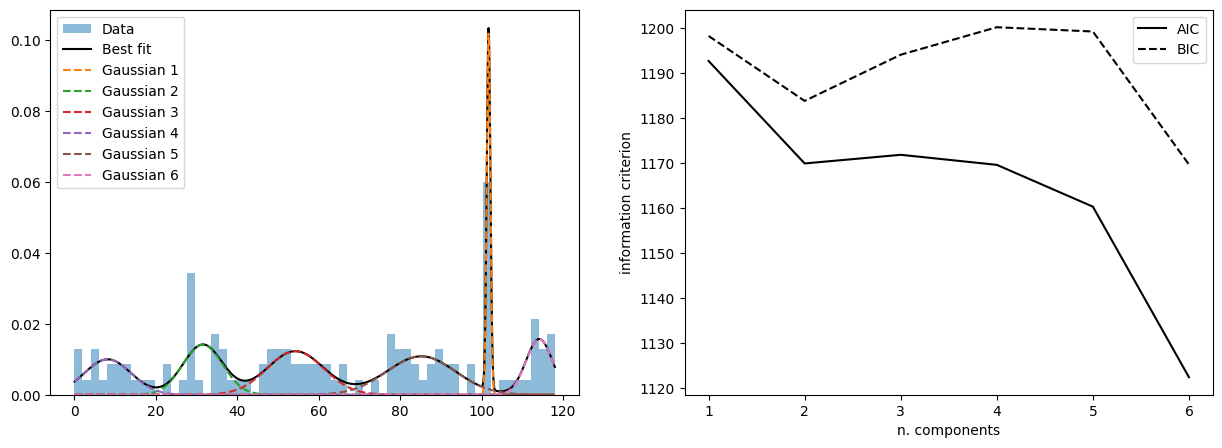

In [159]:
plot_GMM(reqs3.reshape(-1, 1), 6)